### Preprocessing

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import xgboost as xgb

# load data
data = pd.read_csv('C:/Users/Melanie/OneDrive/Projects/In Progress/Dropout/data_clean.csv')
X, y = data.drop('Target', axis=1), data['Target']

# cast nominal data to dtype Category so that xgboost can handle them internally
# (since dataset already encodes nominal features numerically, we must manually specify them)
nominal = [
            'Marital status',      
            'Application mode',          
            'Application order',         
            'Course',                    
            'Daytime/evening attendance',
            'Previous qualification',    
            'Nationality',               
            "Mother's qualification",    
            "Father's qualification",    
            "Mother's occupation",       
            "Father's occupation",       
            'Displaced',              
            'Educational special needs', 
            'Debtor',                    
            'Tuition fees up to date',   
            'Gender',                                              
            'Scholarship holder',                                  
            'International'
            ]

# in 'Nationality' map values for foreign students to 0 to avoid extreme sparsity
X['Nationality'] = X['Nationality'].apply(lambda x: x if x == 1 else 0)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# one-hot encode
encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', drop='first')

fit_train = encoder.fit(X_train[nominal])
fit_test = encoder.fit(X_test[nominal])

encoded_train = encoder.transform(X_train[nominal])
encoded_test = encoder.transform(X_test[nominal])

one_hot_train = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(nominal))
one_hot_test = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(nominal))

X_train_oh = pd.concat([X_train.reset_index(drop=True), 
                     one_hot_train.reset_index(drop=True)], 
                     axis=1)

X_test_oh = pd.concat([X_test.reset_index(drop=True), 
                     one_hot_test.reset_index(drop=True)], 
                     axis=1)

X_train = X_train_oh.drop(nominal, axis=1)
X_test = X_test_oh.drop(nominal, axis=1)


c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 5, 7, 8, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Preliminary Model

In [5]:
# train
clf_vanilla = xgb.XGBClassifier(objective='binary:logistic', 
                                 tree_method='hist', 
                                 early_stopping_rounds=10,
                                 eval_metric='aucpr',
                                 device='cuda', 
                                 seed=1)
clf_vanilla.fit(X_train,
                y_train,
               verbose=True,
               eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.82645
[1]	validation_0-aucpr:0.83856
[2]	validation_0-aucpr:0.84363
[3]	validation_0-aucpr:0.85020
[4]	validation_0-aucpr:0.85578
[5]	validation_0-aucpr:0.85971
[6]	validation_0-aucpr:0.85743
[7]	validation_0-aucpr:0.85642
[8]	validation_0-aucpr:0.86168
[9]	validation_0-aucpr:0.86049
[10]	validation_0-aucpr:0.86127
[11]	validation_0-aucpr:0.86292
[12]	validation_0-aucpr:0.86056
[13]	validation_0-aucpr:0.86324
[14]	validation_0-aucpr:0.86302
[15]	validation_0-aucpr:0.86229
[16]	validation_0-aucpr:0.86260
[17]	validation_0-aucpr:0.86284
[18]	validation_0-aucpr:0.86400
[19]	validation_0-aucpr:0.86240
[20]	validation_0-aucpr:0.86446
[21]	validation_0-aucpr:0.86470
[22]	validation_0-aucpr:0.86450
[23]	validation_0-aucpr:0.86373
[24]	validation_0-aucpr:0.86350
[25]	validation_0-aucpr:0.86374
[26]	validation_0-aucpr:0.86458
[27]	validation_0-aucpr:0.86417
[28]	validation_0-aucpr:0.86652
[29]	validation_0-aucpr:0.86480
[30]	validation_0-aucpr:0.86497
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

c:\Users\Melanie\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


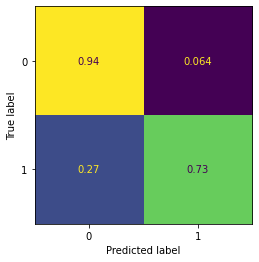

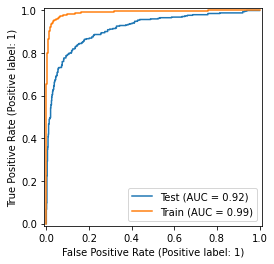

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_vanilla, X_test, y_test, normalize='true', colorbar=False)

# auc
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf_vanilla, X_test, y_test, ax=ax, name='Test')
train_auc = RocCurveDisplay.from_estimator(clf_vanilla, X_train, y_train, ax=ax, name='Train')

plt.show()

0.64% of true negative cases are falsely predicted. 27% of true positive cases are falsely predicted. That's a huge rate of false negatives, but we'd rather have a bias toward false positives. Scale weight will probably be the most important thing to optimize. <br>
Also, the model is clearly overfitting with a 0.7 difference in train and test AUC scores. 

### Grid Search Round 1

In [5]:
from sklearn.model_selection import GridSearchCV

default_weight = sum(y_train==0) / sum(y_train==1)

grid = {
    'max_depth':[3, 4, 5],
    'learning_rate':[0.1, 0.01, 0.05],
    'gamma':[0, 0.25, 1.0],
    'reg_lambda':[0, 1.0, 10.0],
    'scale_pos_weight':[default_weight - 1, default_weight, default_weight + 1]
}

gs = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic', 
                                 tree_method='hist', 
                                 subsample=0.9,
                                 colsample_bytree=0.5,
                                 device='cuda', 
                                 seed=1),
    param_grid=grid,
    scoring=['accuracy', 'recall', 'f1'], 
    return_train_score=True, 
    refit=False
)

y_train_np = y_train.to_numpy()
y_train_np = y_train_np.ravel()

gs.fit(X_train, y_train_np)

# see results
gs_results = pd.DataFrame(gs.cv_results_)


In [6]:
cols = ['param_gamma',
        'param_learning_rate',
        'param_max_depth',
        'param_reg_lambda',
        'param_scale_pos_weight',
        'mean_test_accuracy',
        'mean_train_accuracy',
        'mean_test_recall',
        'mean_test_f1']

gs_results[cols].sort_values(by='mean_test_f1', axis=0, ascending=False, ignore_index=True)

,param_gamma,param_learning_rate,param_max_depth,param_reg_lambda,param_scale_pos_weight,mean_test_accuracy,mean_train_accuracy,mean_test_recall,mean_test_f1
0,0.00,0.10,5,1.0,1.11257,0.881856,0.942812,0.752380,0.803479
1,0.25,0.05,5,0.0,2.11257,0.873717,0.931812,0.798328,0.802379
2,1.00,0.10,5,1.0,1.11257,0.880955,0.939497,0.749563,0.801654
3,1.00,0.05,4,0.0,2.11257,0.871606,0.904611,0.806770,0.801400
4,0.25,0.10,5,1.0,1.11257,0.881254,0.943490,0.746755,0.801395
...,...,...,...,...,...,...,...,...,...
238,0.25,0.01,4,10.0,1.11257,0.850810,0.863397,0.594765,0.718959
239,0.00,0.01,4,10.0,1.11257,0.850508,0.863321,0.593827,0.718165
240,0.00,0.01,3,10.0,1.11257,0.847798,0.855184,0.584454,0.711369
241,1.00,0.01,3,10.0,1.11257,0.847798,0.855410,0.584454,0.711369


Highest recall is given by learning rate 0.01, max depth 4/5, lambda 10, scale weight 3.11. Maxing recall (0.86) causes a significant loss in accuracy (0.80). Need to compromise. <br>
Highest f1 is given by learning rate 0.1/0.5, max depth 5, lambda 1/0, scale weight 1.11/2.11. Maxing f1 (0.80) maintains high accuracy (0.88) with some overfitting (train accuracy 0.94). Causes modest loss in recall (0.75). <br>
Highest accuracy is given by learning rate 0.1, max depth 5, lambda 1, scale weight 1.11. Scores across the board match with maxing f1. <br><br>

F1 and accuracy seem to be synchronous with each other, but recall is not. Note that the best params for recall are different from the best params for accuracy and f1. Maxing recall sacrafices too much accuracy, and maxing accuracy or f1 introduces overfitting. <br>
The best approach may be to maximize f1 while reducing the overfitting, then adjusting the decision threshold. <br>
The model appears to be insensitive to gamma. <br>


Let's look at the difference between the test and train ROC curves for the model with the highest test f1 score.

In [7]:
clf_f1 = xgb.XGBClassifier(objective='binary:logistic', 
                            tree_method='hist', 
                            early_stopping_rounds=10,
                            eval_metric='aucpr',
                            gamma=0.0,
                            learning_rate=0.1,
                            max_depth=5,
                            reg_lamdba=1.0,
                            device='cuda', 
                            seed=1)
clf_f1.fit(X_train,
            y_train,
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.82383
[1]	validation_0-aucpr:0.83857
[2]	validation_0-aucpr:0.83960
[3]	validation_0-aucpr:0.84147
[4]	validation_0-aucpr:0.84022
[5]	validation_0-aucpr:0.84054
[6]	validation_0-aucpr:0.84478
[7]	validation_0-aucpr:0.84869
[8]	validation_0-aucpr:0.84915
[9]	validation_0-aucpr:0.84997
[10]	validation_0-aucpr:0.85178
[11]	validation_0-aucpr:0.85352
[12]	validation_0-aucpr:0.85506
[13]	validation_0-aucpr:0.85540
[14]	validation_0-aucpr:0.85565
[15]	validation_0-aucpr:0.85592
[16]	validation_0-aucpr:0.85555
[17]	validation_0-aucpr:0.85659


c:\Users\Melanie\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "reg_lamdba" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-aucpr:0.85642
[19]	validation_0-aucpr:0.85704
[20]	validation_0-aucpr:0.85664
[21]	validation_0-aucpr:0.85643
[22]	validation_0-aucpr:0.85721
[23]	validation_0-aucpr:0.85781
[24]	validation_0-aucpr:0.85697
[25]	validation_0-aucpr:0.85874
[26]	validation_0-aucpr:0.86047
[27]	validation_0-aucpr:0.86003
[28]	validation_0-aucpr:0.86049
[29]	validation_0-aucpr:0.85997
[30]	validation_0-aucpr:0.86184
[31]	validation_0-aucpr:0.86087
[32]	validation_0-aucpr:0.86346
[33]	validation_0-aucpr:0.86382
[34]	validation_0-aucpr:0.86350
[35]	validation_0-aucpr:0.86276
[36]	validation_0-aucpr:0.86252
[37]	validation_0-aucpr:0.86317
[38]	validation_0-aucpr:0.86367
[39]	validation_0-aucpr:0.86319
[40]	validation_0-aucpr:0.86317
[41]	validation_0-aucpr:0.86353
[42]	validation_0-aucpr:0.86319
[43]	validation_0-aucpr:0.86338


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

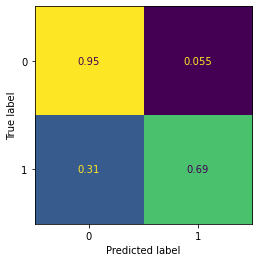

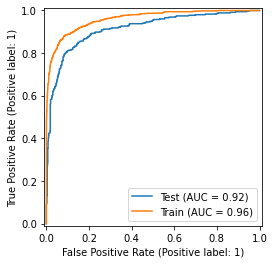

In [14]:
# confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_f1, X_test, y_test, normalize='true', colorbar=False)

# auc
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf_f1, X_test, y_test, ax=ax, name='Test')
train_auc = RocCurveDisplay.from_estimator(clf_f1, X_train, y_train, ax=ax, name='Train')

plt.show()

The ratio of false positives to false negatives is even more imbalanced than the preliminary model. The model is still overfitting, though less so, with a 0.4 difference between train and test AUC scores. <br>
We'll seek to reduce the overfitting and then tune the decision threshold. 

### Grid Search Round 2

These are the parameters we'll tweak along with the direction we likely want: <br><br>
    colsample_bytree -- decrease<br>
    subsample -- decrease<br>
    max_depth -- decrease<br>
    gamma -- increase<br>
    learning_rate -- decrease<br>
    min_child_weight -- increase<br><br>

We'll lower the value of early_stopping_rounds as well.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

grid = {
    'colsample_bytree':[0.3, 0.5, 0.7],
    'subsample':[0.5, 0.7, 0.9],
    'max_depth':[3, 5, 7],
    'gamma':[0.5, 0.7, 0.9],
    'learning_rate':[0.01, 0.1, 0.3],
    'min_child_weight':[5, 8, 11],
    'reg_lambda':[1.0, 4.0, 7.0],
    'n_estimators':[50, 200, 500]
}

gs = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic', 
                                 tree_method='hist', 
                                 seed=1),
    param_grid=grid,
    scoring=['accuracy', 'roc_auc'], 
    return_train_score=True, 
    refit=False
)

y_train_np = y_train.to_numpy()
y_train_np = y_train_np.ravel()

gs.fit(X_train, y_train_np)

# save results
gs_results = pd.DataFrame(gs.cv_results_)

In [14]:
# add column for the difference between train and test auc scores
gs_results['diff_auc'] = gs_results['mean_train_roc_auc'] - gs_results['mean_test_roc_auc']

# define columns of interest
cols = ['param_colsample_bytree', 
        'param_gamma', 
        'param_learning_rate',
        'param_max_depth',
        'param_min_child_weight', 
        'param_n_estimators',
        'param_reg_lambda', 
        'param_subsample',
        'mean_test_accuracy',
        'diff_auc']

# show results
gs_results[cols].sort_values(by='diff_auc', axis=0, ascending=True, ignore_index=True)


,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_lambda,param_subsample,mean_test_accuracy,diff_auc
0,0.3,0.9,0.01,3,11,50,7.0,0.5,0.760396,0.006406
1,0.3,0.5,0.01,3,11,50,7.0,0.5,0.761905,0.006437
2,0.3,0.7,0.01,3,11,50,7.0,0.5,0.760095,0.006441
3,0.3,0.9,0.01,3,11,50,4.0,0.5,0.772153,0.006647
4,0.3,0.7,0.01,3,11,50,4.0,0.5,0.772153,0.006670
...,...,...,...,...,...,...,...,...,...,...
6556,0.7,0.9,0.30,7,5,500,1.0,0.5,0.851109,0.110964
6557,0.7,0.9,0.30,7,8,500,1.0,0.5,0.854730,0.111368
6558,0.5,0.9,0.30,7,8,500,1.0,0.5,0.848096,0.111938
6559,0.7,0.7,0.30,5,5,500,1.0,0.5,0.848999,0.112077


Now we've achieved nearly identical roc-auc scores from both training and testing but with a big sacrifice in accuracy. Now, we need to select a model from among these that is neither overfitting nor underfitting. 

In [21]:
# find model with highest accuracy where diff auc is below a threshold

low_diff = gs_results[gs_results['diff_auc'] < 0.05]
max_acc_idx = low_diff['mean_test_accuracy'].idxmax()
max_acc = low_diff.loc[[max_acc_idx]]
print(f'For models where the difference between train and test AUC scores is < 0.05, the highest accuracy is {max_acc}.')

In [31]:
# fit the model with the optimal hyperparameters

clf_tuned = xgb.XGBClassifier(objective='binary:logistic', 
                                tree_method='hist', 
                                early_stopping_rounds=5,
                                eval_metric='aucpr',
                                device='cuda', 
                                seed=1,
                                gamma=0.5,
                                learning_rate=0.1,
                                max_depth=5,
                                min_child_weight=5,
                                n_estimators=50,
                                reg_lambda=1.0,
                                subsample=0.9,
                                colsample_bytree=0.7)
clf_tuned.fit(X_train,
              y_train,
              eval_set=[(X_test, y_test)])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device='cuda', early_stopping_rounds=5,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

c:\Users\Melanie\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


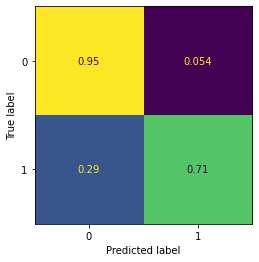

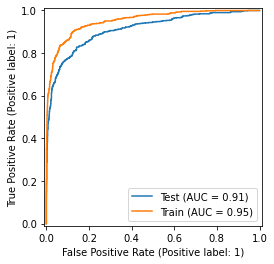

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_tuned, X_test, y_test, normalize='true', colorbar=False)

# roc
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf_tuned, X_test, y_test, ax=ax, name='Test')
train_auc = RocCurveDisplay.from_estimator(clf_tuned, X_train, y_train, ax=ax, name='Train')

plt.show()

### Decision Threshold

Our grid search has produced a model with accuracy = 0.882764 and highly similar ROC curves. This is probably the optimal balance between accuracy and well-generalized fit. Now we'll tune the decision threshold to adjust the ratio of false positives and false negatives.<br>
We'll use Youden's J Statistic to find the threshold closest to the top left corner of the ROC curve. 

Best threshold = 0.2638712227344513


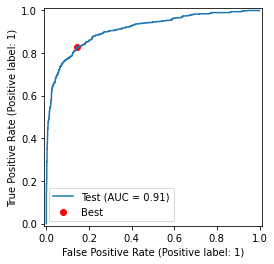

In [8]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt

# get probabilities for the positive case
yhat = clf_tuned.predict_proba(X_test)[:, 1]

# get roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# find best threshold
J = tpr - fpr
idx = np.argmax(J)
best_thresh = thresholds[idx]

print(f'Best threshold = {best_thresh}')

# plot the roc curve showing the optimal threshold
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf_tuned, X_test, y_test, ax=ax, name='Test')
plt.scatter(fpr[idx], tpr[idx], marker='o', color='red', label='Best')
plt.legend()

plt.show()

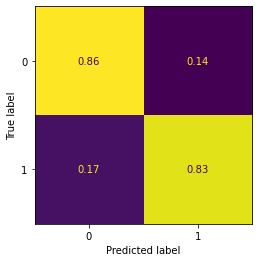

In [9]:
# get class labels using new threshold
y_prob = clf_tuned.predict_proba(X_test)[:, 1]
y_pred = np.where(y_prob > best_thresh, 1, 0)

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', colorbar=False)

Using the new threshold, 16% of true positives are falsely predicted and 14% of true negatives are falsely predicted. This is pretty balanced, but we'd like the false positive rate to be a little higher than the false negative rate (the inverse of what is happening). Let's tweak the threshold just a bit to accomplish this. Let's test a few nearby thresholds using cross validation and see what error ratios they produce.

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# rejoin train and test sets
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y = pd.concat([y_train, y_test], axis=0, ignore_index=True)

# get cv folds
skf = StratifiedKFold()

# create range of thresholds to test
test_thresholds = np.arange(0.20, 0.31, 0.01)

# initialize lists for storage
mean_acc, mean_type_i, mean_type_ii = [], [], []

# test thresholds
for i, threshold in enumerate(test_thresholds):

    acc, type_i, type_ii  = [], [], []

    # for each cv fold
    for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        # train model
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf_tuned.fit(X_train, 
                      y_train,
                      verbose=0, 
                      eval_set=[(X_test, y_test)])
        y_prob = clf_tuned.predict_proba(X_test)[:, 1]
        y_pred = np.where(y_prob > threshold, 1, 0)

        # get errors
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        acc.append(accuracy_score(y_test, y_pred))
        type_i.append(cm[0, 1])
        type_ii.append(cm[1, 0])

    # save error means across folds
    mean_acc.append(np.mean(acc))
    mean_type_i.append(np.mean(type_i))
    mean_type_ii.append(np.mean(type_ii))

# show results
result = pd.DataFrame({'Threshold': test_thresholds,
                       'Accuracy': mean_acc,
                       'Type I Error': mean_type_i,
                       'Type II Error': mean_type_ii})
result

,Threshold,Accuracy,Type I Error,Type II Error
0,0.20,0.809222,0.223104,0.122464
1,0.21,0.817813,0.208784,0.125982
2,0.22,0.825272,0.195132,0.131611
3,0.23,0.827759,0.186141,0.142871
4,0.24,0.832505,0.177486,0.146387
5,0.25,0.836122,0.170160,0.150613
6,0.26,0.841773,0.160837,0.152723
7,0.27,0.846971,0.151845,0.155540
8,0.28,0.849457,0.143190,0.166096
9,0.29,0.851717,0.136527,0.173138


A threshold of 0.27 produces balanced error ratios.<br> 
A threshold of 0.26 is where false positives begin to outnumber false negatives. <br>
Every 0.01 decrease in threshold decreases accuracy by about half a percent.